# Import Python Libaries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams.update({'figure.autolayout': True, 'font.size':20})
import seaborn as sns
%matplotlib inline
import re
import string
import spacy 
import os
import sys
import numpy as np

nlp = spacy.load('en', disable=['ner', 'parser'])
import nltk
from nltk.stem.snowball import SnowballStemmer
from scipy import stats

from time import time
from collections import defaultdict
import gc
import io
import random

from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np
import operator

import nltk
nltk.download('all')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize


import keras
from keras.models import Model, Sequential
from keras.layers import *
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalAveragePooling1D, Dropout, Conv1D, GRU, Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from sklearn.metrics import roc_auc_score
import keras.backend as K
from keras.layers import CuDNNLSTM as LSTM
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras import metrics
from tensorflow.python.keras.metrics import Metric
from tensorflow.keras.utils import plot_model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.utils import shuffle, class_weight
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, roc_auc_score, f1_score, confusion_matrix

from sklearn.pipeline import Pipeline


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

Using TensorFlow backend.


In [0]:
# install tensorflow 2.0
#!pip uninstall tensorflow
#!pip install tensorflow-gpu==2.1.0

In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
# check the availability of GPU
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [0]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### GloVe Pretrained Word Embedding loading

In [0]:
# Load GloVe Embeddings
print('Loading GloVe Embeddings.')

glove_embeddings = {}
f = open('/gdrive/My Drive/glove.42B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_embeddings))


Loading GloVe Embeddings.
Found 1917495 word vectors.


# Import cleaned data

In [0]:
data = pd.read_csv('/gdrive/My Drive/cleaned_data.csv')
data_cleaned = data[['texts','positivity']][data['relevance']==1]

In [0]:
data_cleaned

,texts,positivity
0,yield cd fall late week new york yield cert...,3.0
4,currency trading dollar remain tight range a...,3.0
5,stock fall bofa alcoa slide stock decline ...,3.0
9,u s dollar fall currency decline soften bo...,4.0
12,defend deflation author james b stewartthe...,4.0
...,...,...
7964,housing start grow raise inflation fear ec...,7.0
7965,profit evasive stock mart rally greer philip...,3.0
7975,salomon sound wary note economy clinton admini...,8.0
7978,great terror massive new history hitler tyra...,5.0


In [0]:
data_cleaned.groupby('positivity').count()

,texts
positivity,
2.0,35
3.0,343
4.0,255
5.0,205
6.0,214
7.0,295
8.0,71
9.0,2


# Sentiment Analysis

## Data Augmentation

In [0]:
# use WordNet to find synonyms of each word and oversample the minor class
from nltk.corpus import wordnet 

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

In [0]:
# use the function in Oversampling
def augmentation(wordlist, pos): 
  new_words = wordlist
  for i in range(len(wordlist)):
    for random_word in wordlist[wordlist.index[i]]:
      try:
        synonyms = get_synonyms(random_word)
        synonym = random.choice(list(synonyms))
        new_words[new_words.index[i]] = [synonym if word == random_word else word for word in new_words[new_words.index[i]]]
      except:
        pass
    s = ' '.join(new_words[new_words.index[i]])
    new_words[new_words.index[i]] = s
  augmented_sentences = pd.DataFrame(columns=['texts','positivity'])
  augmented_sentences['texts'] = new_words
  augmented_sentences['positivity']  = pos
  return augmented_sentences

### 20% data augmentation

In [0]:
data_cleaned_1 = data_cleaned.sample(frac=0.2, replace=False, random_state=17)

In [0]:
sentence = data_cleaned_1['texts']
pos = data_cleaned_1['positivity']
word_list = sentence.str.split()

random.seed(55)
data_1 = data_cleaned.append(augmentation(word_list, pos))

In [0]:
data_1 = shuffle(data_1)
data_1.reset_index()

,index,texts,positivity
0,2976,consumer year robust start income spending g...,6.0
1,4008,number unproductive conflict survey illustra...,3.0
2,4576,baker effort see helpful far reach glance tr...,5.0
3,1111,world business special report ranking g...,7.0
4,7927,china lead recovery american consumer strugg...,8.0
...,...,...,...
1699,240,stock edge high ignore bad news economy oi...,3.0
1700,4854,luxury sale rise despite recession despite per...,4.0
1701,761,business finance bad recession great depressio...,7.0
1702,292,u s jobless claim rise week high level ...,3.0


In [0]:
data_1.groupby('positivity').count()

,texts
positivity,
2.0,41
3.0,417
4.0,306
5.0,239
6.0,255
7.0,355
8.0,88
9.0,3


### 50% data augmentation

In [0]:
data_cleaned_2 = data_cleaned.sample(frac=0.5, replace=False, random_state=17)

In [0]:
sentence = data_cleaned_2['texts']
pos = data_cleaned_2['positivity']
word_list = sentence.str.split()

random.seed(55)
data_2 = data_cleaned.append(augmentation(word_list, pos))

In [0]:
data_2 = shuffle(data_2)
data_2.reset_index()

,index,texts,positivity
0,105,thriftiness throw societal securitydepartment ...,7.0
1,2025,risingprices judge leadoff putforward fusillad...,3.0
2,196,leave casualty change job market look lo...,4.0
3,1453,dollar edge participant await release u s em...,4.0
4,4368,trammel money increase realproperty committe r...,3.0
...,...,...,...
2125,2742,u s news hope turnaround grow dimmer worri...,5.0
2126,5281,recession hide virtue wait recession kno...,5.0
2127,2848,party divide gop ' cliff ' idea proposal red...,5.0
2128,931,industrial rise stock average ignore f...,6.0


### 80% data augmentation

In [0]:
data_cleaned_3 = data_cleaned.sample(frac=0.8, replace=False, random_state=17)

In [0]:
sentence = data_cleaned_3['texts']
pos = data_cleaned_3['positivity']
word_list = sentence.str.split()

random.seed(55)
data_3 = data_cleaned.append(augmentation(word_list, pos))

In [0]:
data_3 = shuffle(data_3)
data_3.reset_index()

,index,texts,positivity
0,6774,commercialise spot inviolable earn young ouseo...,2.0
1,1083,ahead tape today market forecast line sandfi...,3.0
2,3391,new year investor rocky begin new york stoc...,3.0
3,1956,credit market spring life sign confidence w...,7.0
4,0,generate d declivity tardy hebdomad raw ork ge...,3.0
...,...,...,...
2551,784,office vacancy decline year time year sur...,5.0
2552,441,dollar drop wake surge yen clinton dispute f...,4.0
2553,941,price gasoline rise pump october u s gasolin...,3.0
2554,2529,consumer cost correct pril rockoil boss compon...,5.0


### 100% data augmentation

In [0]:
sentence = data_cleaned['texts']
pos = data_cleaned['positivity']
word_list = sentence.str.split()

random.seed(55)
data_4 = data_cleaned.append(augmentation(word_list, pos))


In [0]:
data_4 = shuffle(data_4)
data_4.reset_index()

,index,texts,positivity
0,7593,tax cut inflationary study say omb stu...,4.0
1,7378,grade mown assist finance populace debt recapi...,6.0
2,691,recovery philips electronics stall amid crisis...,7.0
3,5540,washington post tuesday august lag i...,4.0
4,3824,potent economical datapoint theme ov regenerat...,7.0
...,...,...,...
2835,6915,plump oldhat dismiss ichardixon predict ew ork...,2.0
2836,7487,onequarter economical ontogeny anatomy rescrip...,6.0
2837,3045,ilarylinton adjutant better sheer productivene...,7.0
2838,3636,datum cause bond price rally purchaser inde...,3.0


### 120% data augmentation

In [0]:
data_cleaned_5 = data_cleaned.sample(frac=0.2, replace=False, random_state=17)

In [0]:
sentence = data_cleaned['texts']
pos = data_cleaned['positivity']
word_list = sentence.str.split()

random.seed(55)
data_5 = data_cleaned.append(augmentation(word_list, pos))

sentence = data_cleaned_5['texts']
pos = data_cleaned_5['positivity']
word_list = sentence.str.split()

random.seed(74)
data_5 = data_5.append(augmentation(word_list, pos))

In [0]:
data_5 = shuffle(data_5)
data_5.reset_index()

,index,texts,positivity
0,709,atomicnumber siemens intelligence nutrient sea...,3.0
1,2071,portrayal saving honorable clock shuddery cloc...,7.0
2,6035,task creativeactivity meliorate moreorless une...,3.0
3,150,livingaccommodations headstart addition uly mu...,6.0
4,2845,dow musterup pullin percentagepoint writer ona...,8.0
...,...,...,...
3119,2890,bank warn st quarter profit miss estimate ch...,3.0
3120,1595,letter editor pump adrenalin anemic economy ...,5.0
3121,6890,unemployment snick anuary unemployment retain ...,7.0
3122,1976,spicy theme chalkboard yard largeminded passup...,4.0


### 150% data augmentation

In [0]:
data_cleaned_6 = data_cleaned.sample(frac=0.5, replace=False, random_state=17)

In [0]:
sentence = data_cleaned['texts']
pos = data_cleaned['positivity']
word_list = sentence.str.split()

random.seed(55)
data_6 = data_cleaned.append(augmentation(word_list, pos))

sentence = data_cleaned_6['texts']
pos = data_cleaned_6['positivity']
word_list = sentence.str.split()

random.seed(74)
data_6 = data_6.append(augmentation(word_list, pos))

In [0]:
data_6 = shuffle(data_6)
data_6.reset_index()

,index,texts,positivity
0,3442,learn federalofficial ' deputation carryout ' ...,4.0
1,3593,dollar skid trader follow lead fall u s stoc...,3.0
2,1005,visa nett acclivity drop picking visa raqiatio...,6.0
3,5867,mob income climbup nosecount authority story p...,7.0
4,3199,look hamstring putup burp source sudeep reddy...,3.0
...,...,...,...
3545,6304,commonplace platter terms gather volume summer...,4.0
3546,2811,economical soothsayer undercut counton lag ver...,7.0
3547,6984,tax increase live let tax thing perspective ...,8.0
3548,5540,ookeraliaferroashington mail ues ug imprison i...,4.0


### 180% data augmentation

In [0]:
data_cleaned_7 = data_cleaned.sample(frac=0.8, replace=False, random_state=17)

In [0]:
sentence = data_cleaned['texts']
pos = data_cleaned['positivity']
word_list = sentence.str.split()

random.seed(55)
data_7 = data_cleaned.append(augmentation(word_list, pos))

sentence = data_cleaned_7['texts']
pos = data_cleaned_7['positivity']
word_list = sentence.str.split()

random.seed(74)
data_7 = data_7.append(augmentation(word_list, pos))

In [0]:
data_7 = shuffle(data_7)
data_7.reset_index()

,index,texts,positivity
0,5789,overdue profit take drive market low overdue...,3.0
1,5257,speculate recession pastime politician carte...,3.0
2,101,eynesian ontogenesis deduction upshot twelvemo...,3.0
3,377,longer date treasury issue bear brunt rate cut...,8.0
4,1359,income uranium sulfur allin puffiness ' sulfur...,7.0
...,...,...,...
3971,306,lookout money economicsystem intensify newly o...,6.0
3972,7487,quarter economic growth figure revise upward ...,6.0
3973,313,outlook fed get box new york economy cont...,7.0
3974,1065,sombreness abstract pensionoff architecturalpl...,7.0


In [0]:
dist = data_7[['positivity','texts']].groupby('positivity').count()
dist

,texts
positivity,
2.0,98
3.0,959
4.0,718
5.0,570
6.0,596
7.0,829
8.0,200
9.0,6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


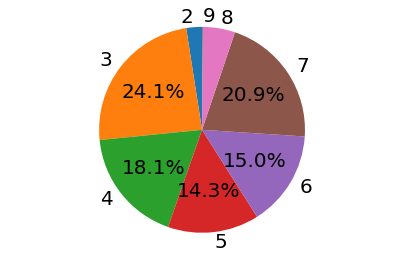

In [0]:
def autopct_generator(limit):
    def inner_autopct(pct):
        return ('%.1f%%' % pct) if pct > limit else ''
    return inner_autopct
plt.rcParams.update({'font.size':20})
fig1, ax1 = plt.subplots()
sizes = dist.values
label = [2,3,4,5,6,7,8,9]
ax1.pie(sizes, labels=label, autopct = autopct_generator(10), startangle=90)
ax1.axis('equal')  

plt.show()

### 200% data augmentation

In [0]:
sentence = data_cleaned['texts']
pos = data_cleaned['positivity']
word_list = sentence.str.split()

random.seed(55)
data_8 = data_cleaned.append(augmentation(word_list, pos))

random.seed(74)
data_8 = data_8.append(augmentation(word_list, pos))

In [0]:
data_8 = shuffle(data_8)
data_8.reset_index()

,index,texts,positivity
0,490,ale cant functionary admonish stimulant value ...,4.0
1,2151,budget surplus certainly fun last enjoy bud...,5.0
2,3680,bernanke chipin odern subscribe prey ichaelack...,5.0
3,2747,nitrogen vitamin siemens tetraiodothyronine ...,3.0
4,1901,inadequate chance fallbehind labor usage fallb...,3.0
...,...,...,...
4255,2531,angstromunit atomicnumber nosecandy group atom...,4.0
4256,1937,task grocerystore reopen grocerystore godown d...,3.0
4257,5866,brand sizeable contempt resolution brand dilig...,3.0
4258,4163,feed move bolster recovery central bank lowe...,6.0


## Baselines

In [0]:
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, multi_class='ovo',average=average)

##### SVM

In [0]:
def svm(data_cleaned):
  texts = data_cleaned['texts'].values
  labels = data_cleaned['positivity'].values

  # Linear SVC Model:
  text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                       ('clf', LinearSVC()),
  ])

  kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state = 7)
  
  # Performance matrix
  scores_svm = pd.DataFrame(columns = ['accuracy','precision', 'recall', 'f1', 'cohen_kappa_score', 'auc'])

  for train, test in kfold.split(texts, labels):
    
    # train model
    text_clf_lsvc.fit(texts[train], labels[train])

    # predictions on test set
    predictions_svm = text_clf_lsvc.predict(texts[test])

    # confusion matrix report
    report = metrics.classification_report(labels[test], predictions_svm, output_dict=True) 
    df = pd.DataFrame(report) 
    print(metrics.classification_report(labels[test], predictions_svm, output_dict=False) )

    # cohen kappa score
    ck = cohen_kappa_score(labels[test], predictions_svm)  

    # auc
    auc = multiclass_roc_auc_score(labels[test], predictions_svm)
    scores_svm = scores_svm.append({'accuracy': df['accuracy'][0], 'precision': df['weighted avg'][0], 
                                    'recall': df['weighted avg'][1], 'f1': df['weighted avg'][2], 
                                    'cohen_kappa_score': ck, 'auc': auc },  ignore_index=True)
  return scores_svm
  

In [0]:
scores_svm_1 = svm(data_1) # 20% data augmentation
scores_svm_2 = svm(data_2) # 50% data augmentation
scores_svm_3 = svm(data_3) # 80% data augmentation
scores_svm_4 = svm(data_4) # 100% data augmentation
scores_svm_5 = svm(data_5) # 120% data augmentation
scores_svm_6 = svm(data_6) # 150% data augmentation
scores_svm_7 = svm(data_7) # 180% data augmentation
scores_svm_8 = svm(data_8) # 200% data augmentation

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         5
         3.0       0.37      0.53      0.43        59
         4.0       0.19      0.20      0.20        44
         5.0       0.06      0.03      0.04        35
         6.0       0.14      0.11      0.12        37
         7.0       0.34      0.44      0.38        50
         8.0       1.00      0.08      0.14        13
         9.0       0.00      0.00      0.00         1

    accuracy                           0.28       244
   macro avg       0.26      0.17      0.16       244
weighted avg       0.28      0.28      0.25       244



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         6
         3.0       0.34      0.56      0.43        59
         4.0       0.28      0.23      0.25        43
         5.0       0.38      0.15      0.21        34
         6.0       0.09      0.08      0.08        37
         7.0       0.24      0.29      0.27        51
         8.0       0.00      0.00      0.00        13
         9.0       0.00      0.00      0.00         1

    accuracy                           0.27       244
   macro avg       0.17      0.16      0.16       244
weighted avg       0.25      0.27      0.25       244



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         6
         3.0       0.34      0.46      0.39        59
         4.0       0.22      0.23      0.23        43
         5.0       0.09      0.06      0.07        34
         6.0       0.38      0.27      0.32        37
         7.0       0.31      0.43      0.36        51
         8.0       0.00      0.00      0.00        13
         9.0       0.00      0.00      0.00         1

    accuracy                           0.29       244
   macro avg       0.17      0.18      0.17       244
weighted avg       0.26      0.29      0.27       244



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         6
         3.0       0.32      0.45      0.38        60
         4.0       0.25      0.25      0.25        44
         5.0       0.25      0.21      0.23        34
         6.0       0.23      0.19      0.21        36
         7.0       0.34      0.37      0.36        51
         8.0       0.00      0.00      0.00        12

    accuracy                           0.29       243
   macro avg       0.20      0.21      0.20       243
weighted avg       0.26      0.29      0.27       243



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         6
         3.0       0.37      0.50      0.43        60
         4.0       0.20      0.16      0.18        44
         5.0       0.17      0.15      0.16        34
         6.0       0.21      0.19      0.20        36
         7.0       0.35      0.43      0.39        51
         8.0       1.00      0.17      0.29        12

    accuracy                           0.30       243
   macro avg       0.33      0.23      0.23       243
weighted avg       0.31      0.30      0.28       243



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         6
         3.0       0.28      0.37      0.32        60
         4.0       0.24      0.23      0.24        44
         5.0       0.17      0.15      0.16        34
         6.0       0.28      0.22      0.25        36
         7.0       0.36      0.45      0.40        51
         8.0       0.00      0.00      0.00        12

    accuracy                           0.28       243
   macro avg       0.19      0.20      0.19       243
weighted avg       0.25      0.28      0.26       243



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         6
         3.0       0.35      0.45      0.39        60
         4.0       0.27      0.30      0.28        44
         5.0       0.17      0.18      0.17        34
         6.0       0.14      0.06      0.08        36
         7.0       0.27      0.34      0.30        50
         8.0       0.00      0.00      0.00        13

    accuracy                           0.27       243
   macro avg       0.17      0.19      0.17       243
weighted avg       0.23      0.27      0.24       243



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         7
         3.0       0.39      0.59      0.47        74
         4.0       0.33      0.30      0.31        56
         5.0       0.19      0.12      0.14        42
         6.0       0.31      0.31      0.31        45
         7.0       0.42      0.42      0.42        65
         8.0       0.33      0.07      0.11        15
         9.0       0.00      0.00      0.00         1

    accuracy                           0.35       305
   macro avg       0.25      0.23      0.22       305
weighted avg       0.33      0.35      0.33       305



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         7
         3.0       0.34      0.43      0.38        75
         4.0       0.18      0.14      0.16        56
         5.0       0.25      0.21      0.23        42
         6.0       0.24      0.18      0.20        45
         7.0       0.39      0.55      0.45        64
         8.0       0.20      0.07      0.10        15
         9.0       0.00      0.00      0.00         1

    accuracy                           0.30       305
   macro avg       0.20      0.20      0.19       305
weighted avg       0.28      0.30      0.28       305



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         7
         3.0       0.35      0.47      0.40        75
         4.0       0.36      0.36      0.36        56
         5.0       0.25      0.14      0.18        42
         6.0       0.33      0.24      0.28        45
         7.0       0.35      0.48      0.41        64
         8.0       0.50      0.07      0.12        15

    accuracy                           0.34       304
   macro avg       0.31      0.25      0.25       304
weighted avg       0.33      0.34      0.32       304



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         7
         3.0       0.32      0.47      0.38        75
         4.0       0.26      0.27      0.26        56
         5.0       0.26      0.22      0.24        41
         6.0       0.44      0.26      0.33        46
         7.0       0.34      0.41      0.37        64
         8.0       1.00      0.07      0.12        15

    accuracy                           0.32       304
   macro avg       0.38      0.24      0.24       304
weighted avg       0.35      0.32      0.31       304



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         7
         3.0       0.43      0.48      0.45        75
         4.0       0.28      0.34      0.31        56
         5.0       0.30      0.24      0.27        41
         6.0       0.16      0.09      0.11        46
         7.0       0.30      0.44      0.36        64
         8.0       0.00      0.00      0.00        15

    accuracy                           0.32       304
   macro avg       0.21      0.23      0.21       304
weighted avg       0.29      0.32      0.30       304



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         7
         3.0       0.39      0.52      0.45        75
         4.0       0.26      0.25      0.26        55
         5.0       0.15      0.10      0.12        42
         6.0       0.38      0.30      0.34        46
         7.0       0.39      0.50      0.44        64
         8.0       0.50      0.13      0.21        15

    accuracy                           0.35       304
   macro avg       0.30      0.26      0.26       304
weighted avg       0.33      0.35      0.33       304



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         6
         3.0       0.35      0.51      0.42        74
         4.0       0.28      0.32      0.30        56
         5.0       0.20      0.12      0.15        42
         6.0       0.26      0.22      0.24        46
         7.0       0.33      0.34      0.34        64
         8.0       0.00      0.00      0.00        15
         9.0       0.00      0.00      0.00         1

    accuracy                           0.31       304
   macro avg       0.18      0.19      0.18       304
weighted avg       0.27      0.31      0.28       304



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         9
         3.0       0.36      0.50      0.42        88
         4.0       0.31      0.31      0.31        67
         5.0       0.29      0.19      0.23        52
         6.0       0.23      0.19      0.21        54
         7.0       0.39      0.47      0.42        77
         8.0       1.00      0.28      0.43        18
         9.0       0.00      0.00      0.00         1

    accuracy                           0.34       366
   macro avg       0.32      0.24      0.25       366
weighted avg       0.35      0.34      0.33       366



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         9
         3.0       0.33      0.42      0.37        88
         4.0       0.28      0.32      0.30        66
         5.0       0.33      0.19      0.24        52
         6.0       0.35      0.31      0.33        54
         7.0       0.27      0.34      0.30        77
         8.0       0.33      0.05      0.09        19

    accuracy                           0.31       365
   macro avg       0.27      0.23      0.23       365
weighted avg       0.30      0.31      0.29       365



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         9
         3.0       0.34      0.47      0.39        88
         4.0       0.27      0.21      0.24        66
         5.0       0.29      0.23      0.26        53
         6.0       0.30      0.24      0.27        54
         7.0       0.34      0.46      0.39        76
         8.0       0.50      0.16      0.24        19

    accuracy                           0.32       365
   macro avg       0.29      0.25      0.26       365
weighted avg       0.32      0.32      0.31       365



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         9
         3.0       0.36      0.44      0.40        88
         4.0       0.32      0.35      0.33        66
         5.0       0.27      0.23      0.25        52
         6.0       0.31      0.27      0.29        55
         7.0       0.42      0.50      0.46        76
         8.0       1.00      0.11      0.19        19

    accuracy                           0.35       365
   macro avg       0.38      0.27      0.27       365
weighted avg       0.37      0.35      0.34       365



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         9
         3.0       0.41      0.59      0.48        88
         4.0       0.37      0.32      0.34        66
         5.0       0.26      0.23      0.24        52
         6.0       0.37      0.24      0.29        55
         7.0       0.36      0.45      0.40        76
         8.0       0.67      0.11      0.19        18
         9.0       0.00      0.00      0.00         1

    accuracy                           0.37       365
   macro avg       0.30      0.24      0.24       365
weighted avg       0.36      0.37      0.35       365



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         9
         3.0       0.36      0.44      0.40        88
         4.0       0.27      0.26      0.26        66
         5.0       0.32      0.23      0.27        52
         6.0       0.39      0.38      0.39        55
         7.0       0.34      0.45      0.39        76
         8.0       0.33      0.06      0.10        18
         9.0       0.00      0.00      0.00         1

    accuracy                           0.34       365
   macro avg       0.25      0.23      0.23       365
weighted avg       0.33      0.34      0.33       365



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         9
         3.0       0.38      0.52      0.44        88
         4.0       0.26      0.24      0.25        66
         5.0       0.29      0.27      0.28        52
         6.0       0.19      0.15      0.16        55
         7.0       0.38      0.45      0.41        76
         8.0       0.50      0.06      0.10        18
         9.0       0.00      0.00      0.00         1

    accuracy                           0.33       365
   macro avg       0.25      0.21      0.21       365
weighted avg       0.31      0.33      0.31       365



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        10
         3.0       0.38      0.49      0.43        98
         4.0       0.29      0.32      0.30        73
         5.0       0.30      0.22      0.26        58
         6.0       0.40      0.34      0.37        61
         7.0       0.38      0.46      0.41        85
         8.0       0.33      0.05      0.08        21

    accuracy                           0.36       406
   macro avg       0.30      0.27      0.27       406
weighted avg       0.34      0.36      0.34       406



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        10
         3.0       0.32      0.48      0.38        98
         4.0       0.28      0.25      0.26        73
         5.0       0.22      0.14      0.17        58
         6.0       0.40      0.30      0.34        61
         7.0       0.43      0.56      0.49        85
         8.0       1.00      0.10      0.18        20
         9.0       0.00      0.00      0.00         1

    accuracy                           0.35       406
   macro avg       0.33      0.23      0.23       406
weighted avg       0.36      0.35      0.33       406



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        10
         3.0       0.36      0.49      0.42        98
         4.0       0.37      0.33      0.35        73
         5.0       0.37      0.24      0.29        59
         6.0       0.26      0.20      0.22        61
         7.0       0.33      0.48      0.39        84
         8.0       0.50      0.10      0.17        20
         9.0       0.00      0.00      0.00         1

    accuracy                           0.34       406
   macro avg       0.27      0.23      0.23       406
weighted avg       0.34      0.34      0.33       406



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        10
         3.0       0.38      0.53      0.44        98
         4.0       0.29      0.23      0.26        73
         5.0       0.18      0.17      0.17        59
         6.0       0.20      0.15      0.17        61
         7.0       0.37      0.46      0.41        84
         8.0       1.00      0.10      0.18        20
         9.0       0.00      0.00      0.00         1

    accuracy                           0.32       406
   macro avg       0.30      0.21      0.20       406
weighted avg       0.33      0.32      0.30       406



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        10
         3.0       0.36      0.52      0.43        98
         4.0       0.24      0.22      0.23        73
         5.0       0.30      0.25      0.28        59
         6.0       0.30      0.23      0.26        61
         7.0       0.33      0.39      0.36        84
         8.0       0.00      0.00      0.00        20
         9.0       0.00      0.00      0.00         1

    accuracy                           0.32       406
   macro avg       0.19      0.20      0.19       406
weighted avg       0.29      0.32      0.30       406

              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        10
         3.0       0.36      0.50      0.42        98
         4.0       0.33      0.33      0.33        73
         5.0       0.31      0.31      0.31        59
         6.0       0.27      0.20      0.23        61
         7.0       0.37 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        11
         3.0       0.38      0.58      0.46       109
         4.0       0.41      0.45      0.43        80
         5.0       0.31      0.21      0.25        63
         6.0       0.28      0.21      0.24        67
         7.0       0.42      0.45      0.44        93
         8.0       0.33      0.04      0.08        23
         9.0       0.00      0.00      0.00         1

    accuracy                           0.38       447
   macro avg       0.27      0.24      0.24       447
weighted avg       0.36      0.38      0.35       447



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        11
         3.0       0.40      0.50      0.44       109
         4.0       0.34      0.32      0.33        81
         5.0       0.46      0.35      0.40        63
         6.0       0.26      0.24      0.25        67
         7.0       0.40      0.51      0.45        93
         8.0       0.60      0.14      0.22        22
         9.0       0.00      0.00      0.00         1

    accuracy                           0.38       447
   macro avg       0.31      0.26      0.26       447
weighted avg       0.37      0.38      0.37       447

              precision    recall  f1-score   support

         2.0       1.00      0.18      0.31        11
         3.0       0.36      0.50      0.42       109
         4.0       0.34      0.33      0.33        80
         5.0       0.29      0.25      0.27        64
         6.0       0.29      0.22      0.25        67
         7.0       0.42 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        11
         3.0       0.42      0.63      0.50       109
         4.0       0.32      0.31      0.32        80
         5.0       0.31      0.22      0.26        64
         6.0       0.35      0.28      0.31        67
         7.0       0.47      0.51      0.49        92
         8.0       1.00      0.13      0.23        23

    accuracy                           0.40       446
   macro avg       0.41      0.30      0.30       446
weighted avg       0.41      0.40      0.38       446



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       1.00      0.10      0.18        10
         3.0       0.40      0.56      0.47       108
         4.0       0.38      0.34      0.36        80
         5.0       0.26      0.16      0.19        64
         6.0       0.37      0.33      0.35        67
         7.0       0.42      0.55      0.48        93
         8.0       0.67      0.17      0.28        23
         9.0       0.00      0.00      0.00         1

    accuracy                           0.39       446
   macro avg       0.44      0.27      0.29       446
weighted avg       0.40      0.39      0.38       446



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        11
         3.0       0.38      0.57      0.45       108
         4.0       0.28      0.26      0.27        80
         5.0       0.28      0.24      0.26        63
         6.0       0.29      0.16      0.21        67
         7.0       0.35      0.40      0.37        93
         8.0       0.25      0.09      0.13        23
         9.0       0.00      0.00      0.00         1

    accuracy                           0.33       446
   macro avg       0.23      0.22      0.21       446
weighted avg       0.31      0.33      0.31       446



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        11
         3.0       0.43      0.52      0.47       108
         4.0       0.28      0.24      0.26        80
         5.0       0.31      0.24      0.27        63
         6.0       0.25      0.25      0.25        67
         7.0       0.36      0.49      0.42        93
         8.0       1.00      0.13      0.23        23
         9.0       0.00      0.00      0.00         1

    accuracy                           0.35       446
   macro avg       0.33      0.23      0.24       446
weighted avg       0.36      0.35      0.33       446



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        12
         3.0       0.43      0.57      0.49       123
         4.0       0.41      0.35      0.38        93
         5.0       0.34      0.27      0.30        71
         6.0       0.38      0.26      0.31        77
         7.0       0.39      0.53      0.45       106
         8.0       0.55      0.24      0.33        25
         9.0       0.00      0.00      0.00         1

    accuracy                           0.40       508
   macro avg       0.31      0.28      0.28       508
weighted avg       0.39      0.40      0.39       508



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        12
         3.0       0.43      0.60      0.50       123
         4.0       0.35      0.35      0.35        93
         5.0       0.33      0.21      0.26        71
         6.0       0.33      0.24      0.27        76
         7.0       0.46      0.56      0.50       107
         8.0       0.67      0.24      0.35        25

    accuracy                           0.41       507
   macro avg       0.37      0.32      0.32       507
weighted avg       0.39      0.41      0.39       507

              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        12
         3.0       0.43      0.63      0.51       124
         4.0       0.45      0.41      0.43        92
         5.0       0.45      0.30      0.36        71
         6.0       0.42      0.32      0.36        76
         7.0       0.48      0.57      0.52       107
         8.0       0.86 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       1.00      0.27      0.43        11
         3.0       0.46      0.62      0.53       124
         4.0       0.37      0.35      0.36        92
         5.0       0.40      0.32      0.36        71
         6.0       0.34      0.29      0.31        76
         7.0       0.45      0.52      0.48       106
         8.0       1.00      0.15      0.27        26
         9.0       0.00      0.00      0.00         1

    accuracy                           0.43       507
   macro avg       0.50      0.32      0.34       507
weighted avg       0.45      0.43      0.41       507



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.50      0.08      0.14        12
         3.0       0.42      0.56      0.48       124
         4.0       0.38      0.39      0.39        92
         5.0       0.31      0.28      0.29        71
         6.0       0.43      0.33      0.37        76
         7.0       0.44      0.49      0.46       106
         8.0       0.86      0.24      0.38        25
         9.0       0.00      0.00      0.00         1

    accuracy                           0.41       507
   macro avg       0.42      0.30      0.31       507
weighted avg       0.43      0.41      0.40       507



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       1.00      0.08      0.15        12
         3.0       0.41      0.47      0.44       124
         4.0       0.36      0.42      0.39        92
         5.0       0.31      0.24      0.27        71
         6.0       0.30      0.32      0.31        76
         7.0       0.39      0.45      0.42       106
         8.0       0.75      0.12      0.21        25
         9.0       0.00      0.00      0.00         1

    accuracy                           0.37       507
   macro avg       0.44      0.26      0.27       507
weighted avg       0.40      0.37      0.36       507



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        12
         3.0       0.41      0.47      0.44       124
         4.0       0.47      0.52      0.49        92
         5.0       0.35      0.27      0.30        71
         6.0       0.40      0.32      0.35        76
         7.0       0.41      0.56      0.47       106
         8.0       0.80      0.16      0.27        25
         9.0       0.00      0.00      0.00         1

    accuracy                           0.42       507
   macro avg       0.36      0.29      0.29       507
weighted avg       0.42      0.42      0.40       507

              precision    recall  f1-score   support

         2.0       1.00      0.07      0.13        14
         3.0       0.48      0.58      0.53       137
         4.0       0.41      0.43      0.42       103
         5.0       0.47      0.41      0.44        82
         6.0       0.47      0.39      0.43        85
         7.0       0.50 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       1.00      0.14      0.25        14
         3.0       0.48      0.64      0.55       137
         4.0       0.46      0.43      0.44       103
         5.0       0.45      0.30      0.36        81
         6.0       0.43      0.34      0.38        85
         7.0       0.51      0.69      0.58       118
         8.0       0.62      0.17      0.27        29
         9.0       0.00      0.00      0.00         1

    accuracy                           0.48       568
   macro avg       0.49      0.34      0.35       568
weighted avg       0.49      0.48      0.46       568



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       1.00      0.07      0.13        14
         3.0       0.41      0.52      0.46       137
         4.0       0.45      0.37      0.40       103
         5.0       0.46      0.48      0.47        81
         6.0       0.37      0.31      0.34        85
         7.0       0.45      0.54      0.49       118
         8.0       0.83      0.34      0.49        29
         9.0       0.00      0.00      0.00         1

    accuracy                           0.44       568
   macro avg       0.50      0.33      0.35       568
weighted avg       0.46      0.44      0.43       568



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        14
         3.0       0.46      0.60      0.52       137
         4.0       0.38      0.35      0.36       103
         5.0       0.40      0.27      0.32        81
         6.0       0.35      0.26      0.30        85
         7.0       0.41      0.58      0.48       118
         8.0       0.73      0.28      0.40        29
         9.0       0.00      0.00      0.00         1

    accuracy                           0.42       568
   macro avg       0.34      0.29      0.30       568
weighted avg       0.41      0.42      0.40       568



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       1.00      0.14      0.25        14
         3.0       0.46      0.55      0.50       137
         4.0       0.40      0.48      0.44       102
         5.0       0.31      0.23      0.27        81
         6.0       0.47      0.36      0.41        86
         7.0       0.47      0.57      0.51       119
         8.0       0.75      0.21      0.33        28
         9.0       0.00      0.00      0.00         1

    accuracy                           0.44       568
   macro avg       0.48      0.32      0.34       568
weighted avg       0.46      0.44      0.43       568



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       1.00      0.07      0.13        14
         3.0       0.49      0.59      0.53       137
         4.0       0.43      0.43      0.43       102
         5.0       0.35      0.30      0.33        82
         6.0       0.52      0.35      0.42        85
         7.0       0.42      0.56      0.48       119
         8.0       0.73      0.29      0.41        28
         9.0       0.00      0.00      0.00         1

    accuracy                           0.45       568
   macro avg       0.49      0.33      0.34       568
weighted avg       0.47      0.45      0.44       568



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)


              precision    recall  f1-score   support

         2.0       1.00      0.07      0.13        14
         3.0       0.50      0.69      0.58       137
         4.0       0.49      0.45      0.47       102
         5.0       0.45      0.35      0.39        82
         6.0       0.42      0.38      0.40        85
         7.0       0.49      0.56      0.52       119
         8.0       0.83      0.18      0.29        28
         9.0       0.00      0.00      0.00         1

    accuracy                           0.48       568
   macro avg       0.52      0.34      0.35       568
weighted avg       0.50      0.48      0.47       568



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        15
         3.0       0.32      0.44      0.37       147
         4.0       0.27      0.25      0.26       110
         5.0       0.23      0.16      0.19        88
         6.0       0.19      0.15      0.17        91
         7.0       0.30      0.38      0.33       127
         8.0       0.25      0.03      0.06        30
         9.0       0.00      0.00      0.00         1

    accuracy                           0.28       609
   macro avg       0.19      0.18      0.17       609
weighted avg       0.26      0.28      0.26       609



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        15
         3.0       0.33      0.46      0.38       147
         4.0       0.26      0.25      0.25       110
         5.0       0.19      0.15      0.17        87
         6.0       0.27      0.20      0.23        92
         7.0       0.29      0.36      0.32       127
         8.0       0.40      0.07      0.11        30
         9.0       0.00      0.00      0.00         1

    accuracy                           0.28       609
   macro avg       0.22      0.18      0.18       609
weighted avg       0.27      0.28      0.27       609



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        15
         3.0       0.34      0.52      0.41       147
         4.0       0.24      0.25      0.25       109
         5.0       0.23      0.15      0.18        88
         6.0       0.28      0.23      0.25        92
         7.0       0.33      0.34      0.34       126
         8.0       0.30      0.10      0.15        31
         9.0       0.00      0.00      0.00         1

    accuracy                           0.30       609
   macro avg       0.21      0.20      0.20       609
weighted avg       0.28      0.30      0.28       609



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        15
         3.0       0.35      0.45      0.39       147
         4.0       0.26      0.27      0.26       109
         5.0       0.26      0.25      0.25        88
         6.0       0.18      0.13      0.15        92
         7.0       0.26      0.30      0.28       126
         8.0       0.29      0.06      0.11        31
         9.0       0.00      0.00      0.00         1

    accuracy                           0.28       609
   macro avg       0.20      0.18      0.18       609
weighted avg       0.26      0.28      0.26       609



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        15
         3.0       0.28      0.36      0.31       147
         4.0       0.24      0.21      0.22       109
         5.0       0.22      0.19      0.21        88
         6.0       0.24      0.22      0.23        92
         7.0       0.29      0.37      0.33       126
         8.0       0.50      0.06      0.11        31

    accuracy                           0.26       608
   macro avg       0.25      0.20      0.20       608
weighted avg       0.26      0.26      0.25       608



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        15
         3.0       0.27      0.40      0.33       147
         4.0       0.26      0.22      0.24       109
         5.0       0.20      0.16      0.18        88
         6.0       0.22      0.17      0.20        92
         7.0       0.28      0.35      0.31       126
         8.0       0.00      0.00      0.00        30
         9.0       0.00      0.00      0.00         1

    accuracy                           0.26       608
   macro avg       0.15      0.16      0.16       608
weighted avg       0.23      0.26      0.24       608

              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        15
         3.0       0.30      0.44      0.36       147
         4.0       0.28      0.24      0.26       109
         5.0       0.28      0.19      0.23        88
         6.0       0.27      0.23      0.25        91
         7.0       0.33 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
print('20% augmentation')
print(scores_svm_1.mean())
print('\n50% augmentation')
print(scores_svm_2.mean())
print('\n80% augmentation')
print(scores_svm_3.mean())
print('\n100% augmentation')
print(scores_svm_4.mean())
print('\n120% augmentation')
print(scores_svm_5.mean())
print('\n150% augmentation')
print(scores_svm_6.mean())
print('\n180% augmentation')
print(scores_svm_7.mean())
print('\n200% augmentation')
print(scores_svm_8.mean())

20% augmentation
accuracy             0.282869
precision            0.262766
recall               0.282869
f1                   0.261733
cohen_kappa_score    0.102516
auc                  0.551854
dtype: float64

50% augmentation
accuracy             0.327698
precision            0.311460
recall               0.327698
f1                   0.307715
cohen_kappa_score    0.157591
auc                  0.578890
dtype: float64

80% augmentation
accuracy             0.337243
precision            0.334660
recall               0.337243
f1                   0.322174
cohen_kappa_score    0.173403
auc                  0.586252
dtype: float64

100% augmentation
accuracy             0.340499
precision            0.336921
recall               0.340499
f1                   0.323694
cohen_kappa_score    0.176649
auc                  0.588014
dtype: float64

120% augmentation
accuracy             0.370354
precision            0.371740
recall               0.370354
f1                   0.353711
cohen_kap

##### XGBoost

In [0]:
def xg(data_cleaned):
  texts = data_cleaned['texts'].values
  labels = data_cleaned['positivity'].values

  # XGBoost Model:
  text_clf_xg = Pipeline([('tfidf', TfidfVectorizer()),
                       ('clf', XGBClassifier()),
  ])

  kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state = 7)
  scores_xg = pd.DataFrame(columns = ['accuracy','precision', 'recall', 'f1', 'cohen_kappa_score','auc'])

  for train, test in kfold.split(texts, labels):

    # train model
    text_clf_xg.fit(texts[train], labels[train])

    # predictions on test set
    predictions_xg = text_clf_xg.predict(texts[test])
    
    # confusion matrix report
    report = metrics.classification_report(labels[test], predictions_xg, output_dict=True)
    df = pd.DataFrame(report)
    #cnf_matrix = confusion_matrix(labels[test], predictions_xg)

    # cohen kappa score
    ck = cohen_kappa_score(labels[test], predictions_xg)

    # auc
    auc = multiclass_roc_auc_score(labels[test], predictions_xg)   

    scores_xg = scores_xg.append({'accuracy': df['accuracy'][0], 'precision': 
                                  df['weighted avg'][0], 'recall': df['weighted avg'][1], 
                                  'f1': df['weighted avg'][2], 'cohen_kappa_score': ck, 'auc':auc },  
                                 ignore_index=True)
  return scores_xg

In [0]:
# model performance using 20% to 200% data augmentation (20%, 50%, 80%, 100%, 120%, 150%, 180%, 200%)
scores_xg_1 = xg(data_1)
scores_xg_2 = xg(data_2)
scores_xg_3 = xg(data_3)
scores_xg_4 = xg(data_4)
scores_xg_5 = xg(data_5)
scores_xg_6 = xg(data_6)
scores_xg_7 = xg(data_7)
scores_xg_8 = xg(data_8)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

In [0]:
print('20% augmentation')
print(scores_xg_1.mean())
print('\n50% augmentation')
print(scores_xg_2.mean())
print('\n80% augmentation')
print(scores_xg_3.mean())
print('\n100% augmentation')
print(scores_xg_4.mean())
print('\n120% augmentation')
print(scores_xg_5.mean())
print('\n150% augmentation')
print(scores_xg_6.mean())
print('\n180% augmentation')
print(scores_xg_7.mean())
print('\n200% augmentation')
print(scores_xg_8.mean())

20% augmentation
accuracy             0.292824
precision            0.261705
recall               0.292824
f1                   0.253625
cohen_kappa_score    0.103635
auc                  0.552055
dtype: float64

50% augmentation
accuracy             0.293430
precision            0.260763
recall               0.293430
f1                   0.255242
cohen_kappa_score    0.100168
auc                  0.549785
dtype: float64

80% augmentation
accuracy             0.298901
precision            0.272969
recall               0.298901
f1                   0.258122
cohen_kappa_score    0.109391
auc                  0.554366
dtype: float64

100% augmentation
accuracy             0.305980
precision            0.287748
recall               0.305980
f1                   0.262967
cohen_kappa_score    0.116630
auc                  0.557741
dtype: float64

120% augmentation
accuracy             0.312747
precision            0.304801
recall               0.312747
f1                   0.271273
cohen_kap

##### Logistic Regression

In [0]:
def lr(data_cleaned):
  texts = data_cleaned['texts'].values
  labels = data_cleaned['positivity'].values

  # Logistic Regression Model:
  text_clf_lr = Pipeline([('tfidf', TfidfVectorizer()),
                       ('clf', LogisticRegression()),
  ])

  kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state = 7)

  # performance matrix
  scores_lr = pd.DataFrame(columns = ['accuracy','precision', 'recall', 'f1', 'cohen_kappa_score', 'auc'])

  for train, test in kfold.split(texts, labels):
    
    # train model
    text_clf_lr.fit(texts[train], labels[train])
    
    # predictions on test set
    predictions_lr = text_clf_lr.predict(texts[test])
    
    # confusion matrix report
    report = metrics.classification_report(labels[test], predictions_lr, output_dict=True)
    df = pd.DataFrame(report)

    ck = cohen_kappa_score(labels[test], predictions_lr)

    # auc
    auc = multiclass_roc_auc_score(labels[test], predictions_lr) 

    scores_lr = scores_lr.append({'accuracy': df['accuracy'][0], 'precision': df['weighted avg'][0], 
                                  'recall': df['weighted avg'][1], 'f1': df['weighted avg'][2], 
                                  'cohen_kappa_score': ck, 'auc': auc },  ignore_index=True)
  return scores_lr

In [0]:
# model performance using 20% to 200% data augmentation (20%, 50%, 80%, 100%, 120%, 150%, 180%, 200%)
scores_lr_1 = lr(data_1)
scores_lr_2 = lr(data_2)
scores_lr_3 = lr(data_3)
scores_lr_4 = lr(data_4)
scores_lr_5 = lr(data_5)
scores_lr_6 = lr(data_6)
scores_lr_7 = lr(data_7)
scores_lr_8 = lr(data_8)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

In [0]:
print('20% augmentation')
print(scores_lr_1.mean())
print('\n50% augmentation')
print(scores_lr_2.mean())
print('\n80% augmentation')
print(scores_lr_3.mean())
print('\n100% augmentation')
print(scores_lr_4.mean())
print('\n120% augmentation')
print(scores_lr_5.mean())
print('\n150% augmentation')
print(scores_lr_6.mean())
print('\n180% augmentation')
print(scores_lr_7.mean())
print('\n200% augmentation')
print(scores_lr_8.mean())

20% augmentation
accuracy             0.312789
precision            0.279192
recall               0.312789
f1                   0.255554
cohen_kappa_score    0.119206
auc                  0.559192
dtype: float64

50% augmentation
accuracy             0.324407
precision            0.287521
recall               0.324407
f1                   0.265791
cohen_kappa_score    0.132561
auc                  0.565877
dtype: float64

80% augmentation
accuracy             0.316513
precision            0.300673
recall               0.316513
f1                   0.262825
cohen_kappa_score    0.126807
auc                  0.562876
dtype: float64

100% augmentation
accuracy             0.322543
precision            0.290624
recall               0.322543
f1                   0.264581
cohen_kappa_score    0.133677
auc                  0.566355
dtype: float64

120% augmentation
accuracy             0.342189
precision            0.311295
recall               0.342189
f1                   0.287298
cohen_kap